In [19]:
from __future__ import print_function
import numpy as np
import pandas as pd
import librosa
import IPython.display as ipd

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [20]:
y, sr = librosa.load("../audio/3dae3e2f-5676-40e4-bf19-cd513c8ffb3f.webm")
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

beat_times = librosa.frames_to_time(beat_frames, sr=sr)
print(beat_times)

Estimated tempo: 86.13 beats per minute
[0.13931973 0.85913832]


In [21]:
ipd.Audio(y, rate=sr*2)

In [22]:
ipd.Audio(y,rate=sr/2)

In [23]:
print(f"Sample rate  :", sr)
print(f"Signal Length:{len(y)}")
print(f"Duration     : {len(y)/sr}seconds")

Sample rate  : 22050
Signal Length:84672
Duration     : 3.84seconds


In [24]:
print("Type  :", type(y))
print("Signal: ", y)
print("Shape :", y.shape)

Type  : <class 'numpy.ndarray'>
Signal:  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.8042719e-05
 -2.5548372e-05 -3.5344372e-05]
Shape : (84672,)



## Waveforms. Amplitude vs Magnitude

A waveform is a curve showing the amplitude of the soundwave (y-axis) at time T (x-axis). Let's check out the waveform of our audio clip


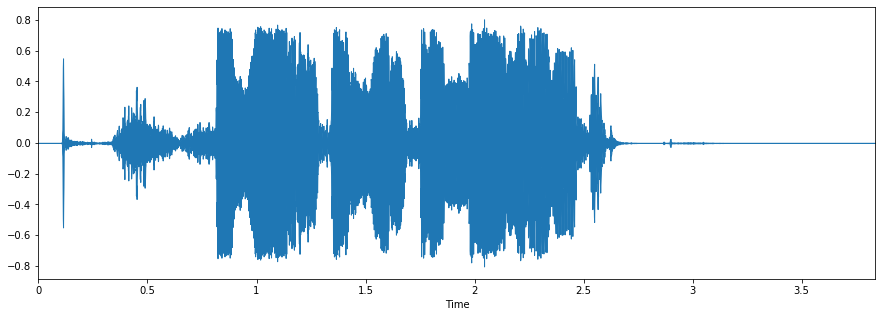

In [25]:
import librosa.display
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y, sr=sr)

## Frequency and Pitch



Most of us remember frequency from physics as cycles per second of a wave. It's the same for sound, but really hard to see in the above image. How many cycles are there? How can there be cycles if it's not regular? The reality is that sound is extremely complex, and the above recording of human speech is the combination of many different frequencies added together. To talk about frequency and pitch, it's easier to start with a pure tone, so let's make one.

Human hearing ranges from 20hz to 20,000hz, hz=hertz=cycles per second. The higher the frequency, the more cycles per second, and the "higher" the pitch sounds to us. To demonstrate, let's make a sound at 500hz, and another at 5000hz.


In [26]:
def make_tone(freq, clip_length=1, sr=16000):
    t = np.linspace(0, clip_length, int(clip_length*sr), endpoint=False)
    return 0.1*np.sin(2*np.pi*freq*t)
clip_500hz = make_tone(500)
clip_5000hz = make_tone(5000)

In [27]:
ipd.Audio(clip_5000hz, rate=sr)

## mel-spectogram

The mel scale is a human-centered metric of audio perception that was developed by asking participants to judge how far apart different tones were. Here is a formula from mel-scale's wikipedia page that you will never need, but might like to see.

Just like frequency, human perception of loudness occurs on a logarithmic scale. A constant increase in the amplitude of a wave will be perceived differently if the original sound is soft or loud.

Decibels measure the ratio of power between 2 sounds, with the main idea being that each 10x increase in the energy of the wave (multiplicative) results in a 10dB increase in sound (additive). Thus something that is 20dB louder has 100x (10*10) the amount of energy, something that is 25dB louder has (10^2.5) = 316.23x more energy.

### Spectogram



Remember how it was impossible to see the smooth cycles and frequencies in the raw waveform graph of our first audio clip? A spectrogram is an almost magical way of breaking a complex signal apart into it's constituent frequencies, and then representing that as an image. Before we get into how this actually happens, let's see what they look like and how to generate and play with them, because this is more important for training your models than actually understanding what a fourier transform is and how it works.

Librosa allows us to generate a spectrogram with the melscale directly using librosa.feature.melspectrogram. To demonstrate why the previous discussion of melscale and decibels was necessary, we'll first display a raw spectrogram with librosa.stft, then a melspectrogram, and then finally a melspectrogram on the decibel scale.

sg = spectrogram, this is a raw energy spectrogram. stft = short-time fourier transform. stft returns a complex result with a real component, the magnitude, and a complex part, the phase. The complex part is typically not used in machine learning applications, but there are a few papers that suggest it is useful so you may want to experiment. For now we will discard it.


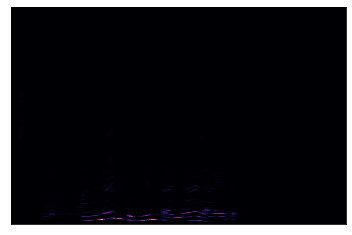

In [28]:
sg0 = librosa.stft(y)
sg_mag, sg_phase = librosa.magphase(sg0)
display(librosa.display.specshow(sg_mag))

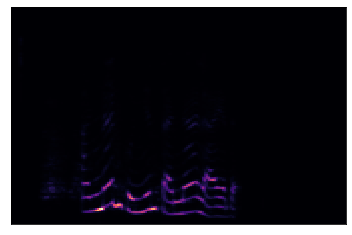

In [29]:
sg1 = librosa.feature.melspectrogram(S=sg_mag, sr=sr)
display(librosa.display.specshow(sg1))

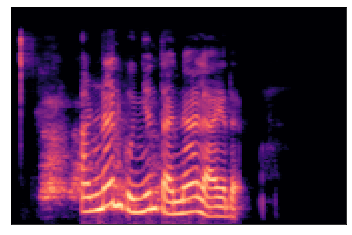

In [30]:
sg2 = librosa.amplitude_to_db(sg1, ref=np.min)
librosa.display.specshow(sg2)

### What's inside a spectogram?



Now we can see, just like when we plotted the audio, the x-axis is time, but now, instead of the amplitude of the wave on the y-axis, we have the frequency. The y-axis is also no longer linear, each new tick doubles the frequency, with a max frequency, or fmax of 8000. Also, this isn't a line graph like the raw waveform, instead of a single value at each timepoint on our x-axis, we have many. Every point in the square represents the energy at the frequency of it's y-coordinate at the time of it's x-coordinate.

Take the point 1.5 seconds in at 1024hz, it appears to be cream colored meaning the energy at that point is somewhere around 80-85db. Meanwhile at that same time, 4096hz appears to be purple and have about 40dB of energy. That means that at t = 1.5 seconds, the sound with 1024hz is around 10000 times louder than sound at 4096hz. 10^((80-40)/10) = 10^4 = 10000.

Let's check out the min, max, and mean of the spectrogram. Remember, the units for these are all decibels.


Text(0.5, 1.0, 'Mel spectrogram')

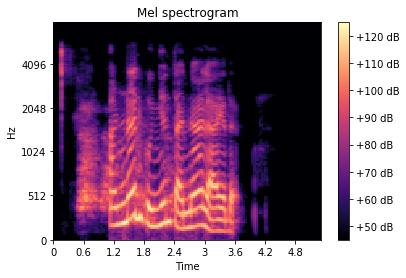

In [31]:
# code adapted from the librosa.feature.melspectrogram documentation
librosa.display.specshow(sg2, sr=16000, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')

In [32]:
sg2.min(), sg2.max(), sg2.mean()

(44.98905, 124.98905, 61.409298)

In [33]:
print(type(sg2))
sg2.shape

<class 'numpy.ndarray'>


(128, 166)

Spectrograms become a lot less magical and a lot easier to work with when you realize they're just 2d numpy arrays. We no longer have to remember and call random functions like librosa.display.specshow, with a little tinkering (converting to pytorch, and adding a unit axis) we can just use fastai's Image()